In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_file
from datetime import datetime
from sklearn.model_selection import train_test_split
from os import path
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.constraints import Constraint
from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import Zeros
from sklearn.metrics import f1_score
import json
import tensorflow_addons as tfa

e:\miniconda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
e:\miniconda\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usi

# Creación de datasets

In [2]:
df = pd.read_csv('train.csv')
#df = df.drop(['classes'], axis=1)
df.head()

,path,food_category,dish,classes
0,images/bibimbap/2857696.jpg,2,69,2 69
1,images/prime_rib/2280209.jpg,2,79,2 79
2,images/chicken_quesadilla/823085.jpg,2,60,2 60
3,images/bread_pudding/3141232.jpg,1,83,1 83
4,images/beignets/2139636.jpg,1,68,1 68


In [3]:
with open('food_categories_dict.json') as f:
    food_categories_dict = json.load(f)
with open('dish_dict.json') as f:
    dish_dict = json.load(f)
print(food_categories_dict)
print(dish_dict)

{'0': 'salad', '1': 'dessert', '2': 'main_dish'}
{'0': 'foie_gras', '1': 'club_sandwich', '2': 'cheese_plate', '3': 'cup_cakes', '4': 'garlic_bread', '5': 'gnocchi', '6': 'ice_cream', '7': 'samosa', '8': 'donuts', '9': 'tuna_tartare', '10': 'filet_mignon', '11': 'seaweed_salad', '12': 'french_toast', '13': 'chicken_curry', '14': 'shrimp_and_grits', '15': 'steak', '16': 'cheesecake', '17': 'red_velvet_cake', '18': 'waffles', '19': 'churros', '20': 'gyoza', '21': 'lobster_roll_sandwich', '22': 'huevos_rancheros', '23': 'breakfast_burrito', '24': 'grilled_cheese_sandwich', '25': 'spaghetti_bolognese', '26': 'falafel', '27': 'poutine', '28': 'greek_salad', '29': 'beef_tartare', '30': 'fried_calamari', '31': 'guacamole', '32': 'ravioli', '33': 'lobster_bisque', '34': 'beet_salad', '35': 'risotto', '36': 'crab_cakes', '37': 'strawberry_shortcake', '38': 'edamame', '39': 'ceviche', '40': 'hot_and_sour_soup', '41': 'spring_rolls', '42': 'sashimi', '43': 'paella', '44': 'clam_chowder', '45': 'm

In [4]:
# train 65% test 25% val 10%
# [Activa] Hipotesis 1: division por clases y subclases equitativa
# Hipotesis 2: division por clases y subclases
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['classes'])
train_df, val_df = train_test_split(train_df, test_size=0.10/0.75, random_state=42, stratify=train_df['classes'])

<Axes: xlabel='food_category'>

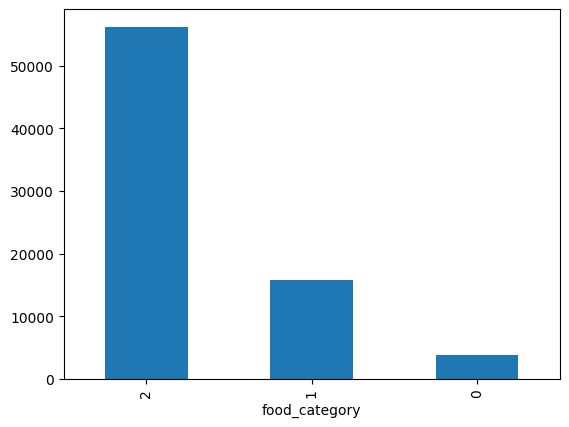

In [5]:
df["food_category"].value_counts().plot(kind='bar')

<Axes: xlabel='food_category'>

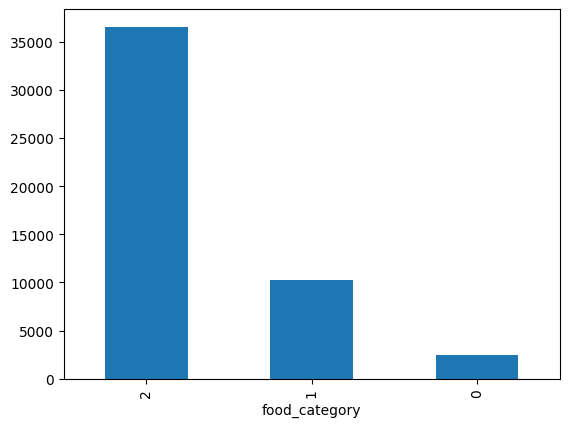

In [6]:
# comparar distribucion de clases de food_category
train_df['food_category'].value_counts().plot(kind='bar')

<Axes: xlabel='food_category'>

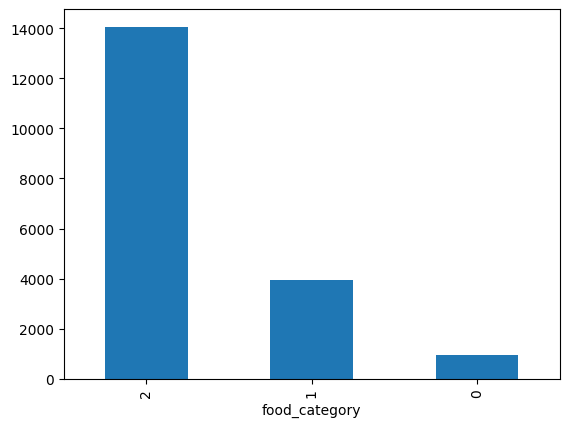

In [7]:
test_df['food_category'].value_counts().plot(kind='bar')

<Axes: xlabel='food_category'>

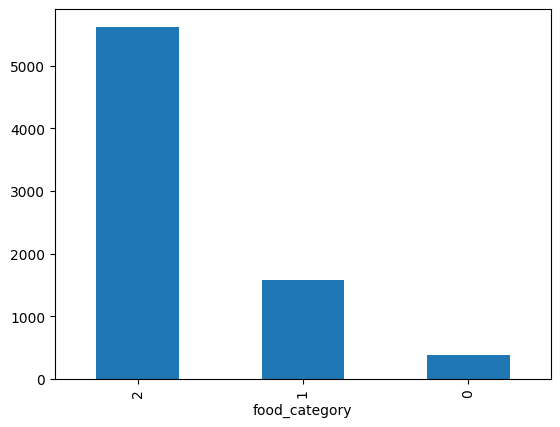

In [8]:
val_df['food_category'].value_counts().plot(kind='bar')

Condition-CNN se beneficia si hay una distribución de pesos similar en los datasets

In [5]:
# One hot encoding for food_category
onehot_food = to_categorical(train_df['food_category'].values)
train_df['food_categoryOneHot'] = onehot_food.tolist()
onehot_food = to_categorical(val_df['food_category'].values)
val_df['food_categoryOneHot'] = onehot_food.tolist()
onehot_food = to_categorical(test_df['food_category'].values)
test_df['food_categoryOneHot'] = onehot_food.tolist()

# One hot encoding for dish
onehot_dish = to_categorical(train_df['dish'].values)
train_df['dishOneHot'] = onehot_dish.tolist()
onehot_dish = to_categorical(val_df['dish'].values)
val_df['dishOneHot'] = onehot_dish.tolist()
onehot_dish = to_categorical(test_df['dish'].values)
test_df['dishOneHot'] = onehot_dish.tolist()


## Funciones para Condition-CNN y Modelo 3

In [6]:
class NonNegUnitNorm(Constraint):
    '''Enforces all weight elements to be non-0 and each column/row to be unit norm'''
    def __init__(self, axis=1):
        self.axis=axis
    def __call__(self, w):
        w = w * math_ops.cast(math_ops.greater_equal(w, 0.), K.floatx())
        return w / (
            K.epsilon() + K.sqrt(
                math_ops.reduce_sum(
                    math_ops.square(w), axis=self.axis, keepdims=True)))

    def get_config(self):
        return {'axis': self.axis}

In [7]:
def get_flow_from_dataframe(g, dataframe,image_shape,batch_size):
    while True:
        x_1 = g.next()
        yield [x_1[0], x_1[1][0]], x_1[1]

# Condition-CNN
Articulo: https://www.sciencedirect.com/science/article/abs/pii/S0957417421006291

In [8]:
# VGG16 pre-trained weights
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='./weights')

## Modelo
Modelo (adaptado) del repositorio en el que se baso el articulo: https://github.com/bKolisnik/Condition-CNN/tree/master

En especifico se uso la implementación Condition-CNN como base.

In [9]:
class ConditionTrain:
    '''This model is based off of VGG16 with the addition of BatchNorm layers and then branching '''

    def __init__(self,label):
        self.master_classes=3
        self.sub_classes=101
        
        '''Three inputs to model for training, image, labels for teacher forcing'''
        input_image = tf.keras.layers.Input(shape=(224,224,3),name="InputImg")

        #3 element vector for the masterCategory types
        input_master = tf.keras.layers.Input(shape=(self.master_classes))

        #Layers are named to be same as VGG16

        #--- block 1 ---
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_image)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

        #--- block 2 ---
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

        #--- block 3 ---
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

        #--- block 4 ---
        x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

        #--- block 5 masterCategory ---
        x1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1_mas')(x)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2_mas')(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3_mas')(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)

        #--- masterCategory prediction branch ---
        c_1_bch = tf.keras.layers.Flatten(name='c1_flatten')(x1)
        c_1_bch = tf.keras.layers.Dense(256, activation='relu', name='c1_fc_mas')(c_1_bch)
        c_1_bch = tf.keras.layers.BatchNormalization()(c_1_bch)
        c_1_bch = tf.keras.layers.Dropout(0.5)(c_1_bch)
        c_1_bch = tf.keras.layers.Dense(256, activation='relu', name='c1_fc2_mas')(c_1_bch)
        c_1_bch = tf.keras.layers.BatchNormalization()(c_1_bch)
        c_1_bch = tf.keras.layers.Dropout(0.5)(c_1_bch)
        c_1_pred = tf.keras.layers.Dense(self.master_classes, activation='softmax', name='master_output')(c_1_bch)

        #--- block 5 subCategory ---
        x2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1_sub')(x)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2_sub')(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3_sub')(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)

        #--- coarse 2 branch ---
        c_2_bch = tf.keras.layers.Flatten(name='c2_flatten')(x2)
        c_2_bch = tf.keras.layers.Dense(1024, activation='relu', name='c2_fc_sub')(c_2_bch)
        c_2_bch = tf.keras.layers.BatchNormalization()(c_2_bch)
        c_2_bch = tf.keras.layers.Dropout(0.5)(c_2_bch)
        c_2_bch = tf.keras.layers.Dense(1024, activation='relu', name='c2_fc2_sub')(c_2_bch)
        c_2_bch = tf.keras.layers.BatchNormalization()(c_2_bch)
        c_2_bch = tf.keras.layers.Dropout(0.5)(c_2_bch)

        #--- masterCategory conditioning for subCategory branch ---
        c_1_condition = tf.keras.layers.Dense(self.sub_classes, activation=None, use_bias=False, kernel_constraint=NonNegUnitNorm(),kernel_initializer=Zeros(),name='c_1_condition')(input_master)
        c_2_raw = tf.keras.layers.Dense(self.sub_classes, activation='relu', name='c_2_raw')(c_2_bch)
        preds_features = tf.keras.layers.Add()([c_1_condition,c_2_raw])
        c_2_pred = tf.keras.layers.Dense(self.sub_classes, activation='softmax', name='sub_output')(preds_features)
        #c_2_pred = tf.keras.layers.Softmax(name='sub_output')(preds_features)

        model = tf.keras.models.Model(
            inputs=[input_image,input_master],
            outputs=[c_1_pred, c_2_pred],
            name="Condition_CNN")

        trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
        #trainable_params = tf.keras.backend.count_params(model.trainable_weights)
        print("Trainable paramaters: "+str(trainable_params))

        losses = {
            "master_output": "categorical_crossentropy",
            "sub_output": "categorical_crossentropy"
        }
        model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=losses,
                        metrics=['categorical_accuracy'])
        
        model.summary()

        checkpoint = ModelCheckpoint("./weights/"+label+"_best_weights_train.h5", monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True,mode='auto')
        self.cbks = [checkpoint]
        self.model = model

class ConditionTest:
    '''One parameter model which is a keras model'''

    def __init__(self,label):

        self.master_classes=3
        self.sub_classes=101


        input_image = tf.keras.layers.Input(shape=(224,224,3),name="InputImg")

        #Layers are named to be same as VGG16

        #will need to center and scale data. -> done in generator

        #--- block 1 ---
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_image)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

        #--- block 2 ---
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

        #--- block 3 ---
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

        #--- block 4 ---
        x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

        #--- block 5 masterCategory ---
        x1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1_mas')(x)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2_mas')(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3_mas')(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)

        #--- masterCategory prediction branch ---
        c_1_bch = tf.keras.layers.Flatten(name='c1_flatten')(x1)
        c_1_bch = tf.keras.layers.Dense(256, activation='relu', name='c1_fc_mas')(c_1_bch)
        c_1_bch = tf.keras.layers.BatchNormalization()(c_1_bch)
        c_1_bch = tf.keras.layers.Dropout(0.5)(c_1_bch)
        c_1_bch = tf.keras.layers.Dense(256, activation='relu', name='c1_fc2_mas')(c_1_bch)
        c_1_bch = tf.keras.layers.BatchNormalization()(c_1_bch)
        c_1_bch = tf.keras.layers.Dropout(0.5)(c_1_bch)
        c_1_pred = tf.keras.layers.Dense(self.master_classes, activation='softmax', name='master_output')(c_1_bch)

        #--- block 5 subCategory ---
        x2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1_sub')(x)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2_sub')(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3_sub')(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)

        #--- coarse 2 branch ---
        c_2_bch = tf.keras.layers.Flatten(name='c2_flatten')(x2)
        c_2_bch = tf.keras.layers.Dense(1024, activation='relu', name='c2_fc_sub')(c_2_bch)
        c_2_bch = tf.keras.layers.BatchNormalization()(c_2_bch)
        c_2_bch = tf.keras.layers.Dropout(0.5)(c_2_bch)
        c_2_bch = tf.keras.layers.Dense(1024, activation='relu', name='c2_fc2_sub')(c_2_bch)
        c_2_bch = tf.keras.layers.BatchNormalization()(c_2_bch)
        c_2_bch = tf.keras.layers.Dropout(0.5)(c_2_bch)

        #--- masterCategory conditioning for subCategory branch ---
        c_1_condition = tf.keras.layers.Dense(self.sub_classes, activation=None, use_bias=False, kernel_constraint=NonNegUnitNorm(),name='c_1_condition')(c_1_pred)
        c_2_raw = tf.keras.layers.Dense(self.sub_classes, activation='relu', name='c_2_raw')(c_2_bch)
        preds_features = tf.keras.layers.Add()([c_1_condition,c_2_raw])
        c_2_pred = tf.keras.layers.Dense(self.sub_classes, activation='softmax', name='sub_output')(preds_features)
        #c_2_pred = tf.keras.layers.Softmax(name='sub_output')(preds_features)

        model = tf.keras.models.Model(
            inputs=[input_image],
            outputs=[c_1_pred, c_2_pred],
            name="Condition_CNN")
        
        losses = {
            "master_output": "categorical_crossentropy",
            "sub_output": "categorical_crossentropy"
        }

        trainable_params= np.sum([K.count_params(w) for w in model.trainable_weights])
        #trainable_params = tf.keras.backend.count_params(model.trainable_weights)
        print("Trainable paramaters: "+str(trainable_params))

        model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=losses,
                        metrics=['categorical_accuracy'])

        checkpoint = ModelCheckpoint("./weights/"+label+"_best_weights.h5", monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True,mode='auto')
        self.cbks = [checkpoint]
        self.model = model

## Opciones

In [10]:
model_type = "Condition"
epochs = 50
batch = 8
target_size = (224, 224)
direc = "./"
TODAY = str(datetime.date(datetime.now()))

In [11]:
# Generador de imagenes
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

# Centrar imagenes
val_datagen = ImageDataGenerator(rescale=1. / 255,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

## Entrenamiento

In [7]:
def train(label, model,cbks):
    model.load_weights(weights_path, by_name=True)
    train = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        class_mode='multi_output')
    val = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        class_mode='multi_output')

    train_generator = get_flow_from_dataframe(train,dataframe=train_df,image_shape=target_size,batch_size=batch)
    val_generator = get_flow_from_dataframe(val,dataframe=val_df,image_shape=target_size,batch_size=batch)
    try:
        STEP_SIZE_TRAIN = train.n // train.batch_size
        STEP_SIZE_VALID = val.n // val.batch_size
        history = model.fit(train_generator,
                            epochs=epochs,
                            validation_data=val_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_steps=STEP_SIZE_VALID,
                            callbacks=cbks)
        print("Finished training")
        
        #Save training as csv
        pd.DataFrame.from_dict(history.history).to_csv("./history/"+label+"_"+str(epochs)+"_epochs_"+TODAY+'.csv',index=False)

        # summarize history for loss
        plt.plot(history.history['master_output_loss'])
        plt.plot(history.history['val_master_output_loss'])
        plt.plot(history.history['sub_output_loss'])
        plt.plot(history.history['val_sub_output_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train master', 'val master', 'train sub', 'val sub'], loc='upper left')
        plt.show()
        plt.savefig("./plots/"+label+"_"+str(epochs)+"_epochs_"+TODAY+"_loss.png", bbox_inches='tight')
    except ValueError as v:
        print(v)

    # Saving the weights in the current directory
    model.save_weights("./weights/"+label+"_"+str(epochs)+"_epochs_"+TODAY+".h5")

Trainable paramaters: 148541461
Model: "Condition_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputImg (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['InputImg[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                     

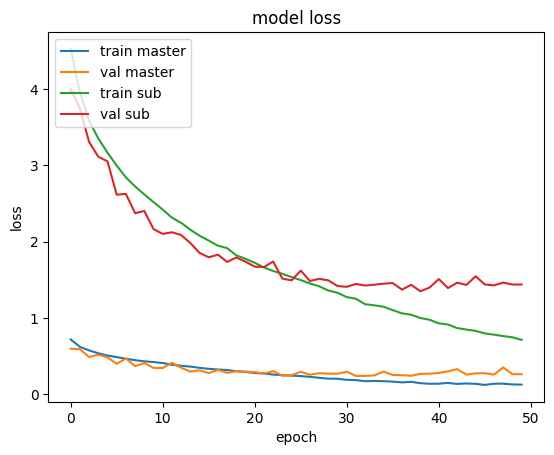

<Figure size 640x480 with 0 Axes>

In [13]:
condition = ConditionTrain(model_type)
model = condition.model
cbks = condition.cbks
train(model_type,model,cbks)

## Test

In [12]:
weights_path_best = "./weights/Condition_best_weights_train.h5"
weights_path_50_epochs = "./weights/Condition_50_epochs_2023-10-30.h5"

In [14]:
def test_multi(label, model, weights_path):
    model.load_weights(weights_path, by_name=True)

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        shuffle=False,
        class_mode='multi_output')

    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    # x can be a generator returning returning (inputs, targets)
    # if x is a generator y should not be specified
    score = model.evaluate(x=test_generator,
        steps=STEP_SIZE_TEST)

    print(f"score is {score}")
    return score

### Con mejores pesos de entrenamiento

In [16]:
model = ConditionTest(model_type).model
score = test_multi(model_type, model, weights_path_best)
params= np.sum([K.count_params(w) for w in model.trainable_weights])
masterCategory_accuracy = score[3]
subCategory_accuracy = score[4]

Trainable paramaters: 148541461
Found 18938 validated image filenames.
2367/2367 [==============================] - 146s 62ms/step - loss: 9422.4014 - master_output_loss: 3564.0127 - sub_output_loss: 5858.3804 - master_output_categorical_accuracy: 0.7426 - sub_output_categorical_accuracy: 0.0167
score is [9422.4013671875, 3564.0126953125, 5858.38037109375, 0.7426066994667053, 0.016740599647164345]


In [18]:
exists = path.exists("./testing/test_results.csv")
if(not exists):
    df_results = pd.DataFrame(columns=['Model','Weights Path', 'masterCategory Accuracy %','subCategory Accuracy %','Trainable params','Timestamp'])
    data = np.empty(0)
    data = np.append(data, [model_type,weights_path_best,masterCategory_accuracy,subCategory_accuracy,params,TODAY])
else:
    df_results = pd.read_csv("./testing/test_results.csv", parse_dates=['Timestamp'])
    
df_results.loc[df.index.max()+1] = [model_type, weights_path_best, masterCategory_accuracy, subCategory_accuracy, params,np.datetime64('now')]
df_results.to_csv("./testing/test_results.csv", index=False)

In [20]:
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        shuffle=False,
        class_mode='multi_output')

results = model.predict(test_generator)

Found 18938 validated image filenames.
2368/2368 [==============================] - 63s 26ms/step


In [22]:
eval_df = pd.DataFrame(results[0].argmax(axis=1), columns=['food_category'])
eval_df['dish'] = results[1].argmax(axis=1)
eval_df['classes'] = eval_df['food_category'].astype(str) + " " + eval_df['dish'].astype(str)
# F1-Score for classes
print(f1_score(test_df['classes'], eval_df['classes'], average='macro'))

0.0008738974985029954


#### Evaluación para submission

In [ ]:
kaggle_df = pd.read_csv('test.csv')
eval_df = kaggle_df.copy()
kaggle_df["food_categoryOneHot"] = [np.zeros(3) for _ in range(len(kaggle_df))]
kaggle_df["dishOneHot"] = [np.zeros(101) for _ in range(len(kaggle_df))]

In [ ]:
images = test_datagen.flow_from_dataframe(
        dataframe=kaggle_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        shuffle=False,
        class_mode='multi_output')
results = model.predict(images)

In [ ]:
eval_df = pd.DataFrame(results[0].argmax(axis=1), columns=['food_category'])
eval_df['dish'] = results[1].argmax(axis=1)
eval_df['classes'] = eval_df['food_category'].astype(str) + " " + eval_df['dish'].astype(str)
eval_df.to_csv('submissions/submission_condition_best_weights.csv', index=False)

### Con pesos establecidos luego de 50 epochs

In [15]:
model = ConditionTest(model_type).model
score = test_multi(model_type, model, weights_path_50_epochs)
params= np.sum([K.count_params(w) for w in model.trainable_weights])
masterCategory_accuracy = score[3]
subCategory_accuracy = score[4]

Trainable paramaters: 148541461
Found 18938 validated image filenames.
2367/2367 [==============================] - 492s 199ms/step - loss: 16792.1250 - master_output_loss: 9878.5020 - sub_output_loss: 6913.6343 - master_output_categorical_accuracy: 0.7426 - sub_output_categorical_accuracy: 0.0111
score is [16792.125, 9878.501953125, 6913.63427734375, 0.7426066994667053, 0.011089987121522427]


In [14]:
exists = path.exists("./testing/test_results.csv")
if(not exists):
    df_results = pd.DataFrame(columns=['Model','Weights Path', 'masterCategory Accuracy %','subCategory Accuracy %','Trainable params','Timestamp'])
    data = np.empty(0)
    data = np.append(data, [model_type,weights_path_50_epochs,masterCategory_accuracy,subCategory_accuracy,params,TODAY])
else:
    df_results = pd.read_csv("./testing/test_results.csv", parse_dates=['Timestamp'])
    
df_results.loc[df.index.max()+1] = [model_type, weights_path_50_epochs, masterCategory_accuracy, subCategory_accuracy, params,np.datetime64('now')]
df_results.to_csv("./testing/test_results.csv", index=False)

In [15]:
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        shuffle=False,
        class_mode='multi_output')

results = model.predict(test_generator)

Found 18938 validated image filenames.
2368/2368 [==============================] - 76s 32ms/step


In [16]:
eval_df = pd.DataFrame(results[0].argmax(axis=1), columns=['food_category'])
eval_df['dish'] = results[1].argmax(axis=1)
eval_df['classes'] = eval_df['food_category'].astype(str) + " " + eval_df['dish'].astype(str)
# F1-Score for classes
print(f1_score(test_df['classes'], eval_df['classes'], average='macro'))

0.24372990911011164


#### Evaluación para submission

In [35]:
kaggle_df = pd.read_csv('test.csv')
eval_df = kaggle_df.copy()
kaggle_df["food_categoryOneHot"] = [np.zeros(3) for _ in range(len(kaggle_df))]
kaggle_df["dishOneHot"] = [np.zeros(101) for _ in range(len(kaggle_df))]

In [36]:
images = test_datagen.flow_from_dataframe(
        dataframe=kaggle_df,
        directory=direc,
        x_col="path",
        y_col=['food_categoryOneHot','dishOneHot'],
        target_size=target_size,
        batch_size=batch,
        shuffle=False,
        class_mode='multi_output')
results = model.predict(images)

Found 25250 validated image filenames.
3157/3157 [==============================] - 101s 32ms/step


In [37]:
eval_df['food_category'] = results[0].argmax(axis=1)
eval_df['dish'] = results[1].argmax(axis=1)
eval_df['classes'] = eval_df['food_category'].astype(str) + " " + eval_df['dish'].astype(str)
eval_df = eval_df.drop(['food_category', 'dish'], axis=1)
eval_df.to_csv('submissions/submission_condition_50_epochs.csv', index=False)